# Gaussian surface approximation code
When an appropriate image is selected, this code is then used to fit a Gaussian surface

In [1]:
# Import packages
import os
import re  # regular expressions
import pathlib
import warnings
import gdal
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import rasterio as rio
from rasterio.plot import plotting_extent
import geopandas as gpd
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
import earthpy.mask as em
import pandas as pd
import pyproj
from pyhdf.SD import SD, SDC
import datetime as dt
import scipy
from scipy import interpolate
import pickle

warnings.simplefilter('ignore')

#Define functions for bit flag interpretation
#bit flag interpretation
#Defining QC functions
#function to check the status of a byte on the QC control
def check_bits(x,n):
    if (x & (1<<n)): 
  ## n-th bit is 1 
        flag = 1
    else:
  ## n-th bit is 0
        flag = 0
    return flag

#function to check bytes 1 and 2 and return 0 if they are both 0
def quality_control(x):
    if ((check_bits(x,1) == 0) and (check_bits(x,2) == 0)):
  ##if bit 1 and bit 2 are 0 then 0 
        flag = 0
    else:
  ##otherwise flag is 1
        flag = 1
    return flag    

In [2]:
#Manual entries
CITY_COUNTRY = "CUIABA_BRAZIL"
City_Lat = -15.59611
City_Lon = -56.09667

#set the fraction of pixels which make the image unusable (if there is a greater number of pixels then this of bad quality, 
#image will not be used)
unusable_cutoff = 0.3

In [18]:
# Set working directory
#MOD11A2 is terra
#MYD11A2 is aqua

#Set path to Terra
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'MODIS_8_day_LST', CITY_COUNTRY,'MOD11A2'))
#set path to current directory
path = pathlib.Path().absolute()
            
#Area to look at will be the city centre +/- 0.25 degs?
min_lat = City_Lat - 0.5
max_lat = City_Lat + 0.5
min_lon = City_Lon - 0.5
max_lon = City_Lon + 0.5

#Read pickle files back in from image select code. Images to be used can be selected from this
with open('Day_list.pkl', 'rb') as f:
    Day_list = pickle.load(f)
    
with open('Night_list.pkl', 'rb') as f:
    Night_list = pickle.load(f)

In [19]:
#file to be used 
#picked at random for now - 4th July 2018
file_name = 'MYD11A2.A2018185.h12v10.006.2018222200322.hdf'

#path to the file
data_path = os.path.join(file_name)

In [20]:
#Extract the subdatasets of interest
#QC is still needed as the pixels which are of bad quality will still need to be removed/ masked 

#LST daytime
with rio.open(data_path) as dataset:
    # Loop through each subdataset in HDF4 file
    for name in dataset.subdatasets:
        
        # Use regular expression to identify if subdataset has LST:LST in the name
        if re.search("LST:LST_Day_1km*", name):
        
            # Open the band subdataset
            with rio.open(name) as subdataset:
                modis_meta = subdataset.profile
                
                # Read band data as a 2 dim arr and append to list
                LST_day = subdataset.read(1)
                
#LST night       
with rio.open(data_path) as dataset:
    # Loop through each subdataset in HDF4 file
    for name in dataset.subdatasets:
        
        # Use regular expression to identify if subdataset has LST:LST in the name
        if re.search("LST:LST_Night_1km*", name):
        
            # Open the band subdataset
            with rio.open(name) as subdataset:
                modis_meta = subdataset.profile
                
                # Read band data as a 2 dim arr and append to list
                LST_night = subdataset.read(1)                
                
                
#QC day      
with rio.open(data_path) as dataset:
    # Loop through each subdataset in HDF4 file
    for name in dataset.subdatasets:
        
        # Use regular expression to identify if subdataset has LST:LST in the name
        if re.search("LST:QC_Day*", name):
        
            # Open the band subdataset
            with rio.open(name) as subdataset:
                modis_meta = subdataset.profile
                
                # Read band data as a 2 dim arr and append to list
                QC_day = subdataset.read(1)   
                
#QC night       
with rio.open(data_path) as dataset:
    # Loop through each subdataset in HDF4 file
    for name in dataset.subdatasets:
        
        # Use regular expression to identify if subdataset has LST:LST in the name
        if re.search("LST:QC_Night*", name):
        
            # Open the band subdataset
            with rio.open(name) as subdataset:
                modis_meta = subdataset.profile
                
                # Read band data as a 2 dim arr and append to list
                QC_night = subdataset.read(1)   
                
                
#Create the coordinate grid
# Identify the data field- use the LST day but grid is same for all data
DATAFIELD_NAME = 'LST_Day_1km'

GRID_NAME = 'MODIS_Grid_8Day_1km_LST'

hdf = SD(file_name, SDC.READ)

# Read dataset.
data2D = hdf.select(DATAFIELD_NAME)
data = data2D[:,:].astype(np.float64)

# Read global attribute.
fattrs = hdf.attributes(full=1)
ga = fattrs["StructMetadata.0"]
gridmeta = ga[0]

# Construct the grid.  Required information in global attribute called 'StructMetadata.0'

ul_regex = re.compile(r'''UpperLeftPointMtrs=\(
                                  (?P<upper_left_x>[+-]?\d+\.\d+)
                                  ,
                                  (?P<upper_left_y>[+-]?\d+\.\d+)
                                  \)''', re.VERBOSE)
match = ul_regex.search(gridmeta)
x0 = np.float(match.group('upper_left_x')) 
y0 = np.float(match.group('upper_left_y')) 

lr_regex = re.compile(r'''LowerRightMtrs=\(
                                  (?P<lower_right_x>[+-]?\d+\.\d+)
                                  ,
                                  (?P<lower_right_y>[+-]?\d+\.\d+)
                                  \)''', re.VERBOSE)
match = lr_regex.search(gridmeta)
x1 = np.float(match.group('lower_right_x')) 
y1 = np.float(match.group('lower_right_y')) 
ny, nx = data.shape
xinc = (x1 - x0) / nx
yinc = (y1 - y0) / ny

x = np.linspace(x0, x0 + xinc*nx, nx)
y = np.linspace(y0, y0 + yinc*ny, ny)
xv, yv = np.meshgrid(x, y)

# convert the grid back to lat/lons.
sinu = pyproj.Proj("+proj=sinu +R=6371007.181 +nadgrids=@null +wktext")
wgs84 = pyproj.Proj("+init=EPSG:4326") 
lon, lat= pyproj.transform(sinu, wgs84, xv, yv)

#Apply scale factors
scale_factor_LST = 0.02

LST_day = LST_day*scale_factor_LST
LST_night = LST_night*scale_factor_LST

#Note: fill value for LST is 0


In [21]:
#Create the lists to be combined to create a dataframe
LST_day_list = LST_day.flatten()
LST_night_list = LST_night.flatten()
QC_day_list = QC_day.flatten()
QC_night_list = QC_night.flatten()
Lon_list = lon.flatten()
Lat_list = lat.flatten()

#Create the dataframe

df = pd.DataFrame(list(zip(LST_day_list, LST_night_list, QC_day_list, QC_night_list, Lon_list, Lat_list)), 
               columns =['LST_day', 'LST_night','QC_day', 'QC_night','Longitude', 'Latitude']) 

#Create dataframe of the required area
df_subset = df[(df.Latitude >min_lat) & (df.Latitude < max_lat) & (df.Longitude > min_lon) & (df.Longitude < max_lon)]

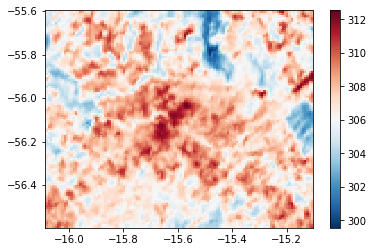

In [22]:
#Check points by plotting
#specify x,y,LSTs
x= df_subset.Latitude
y= df_subset.Longitude
LST = df_subset.LST_day

#get the points into the correct format
X,Y = np.meshgrid(x,y)
Z = scipy.interpolate.griddata((x, y), LST, (X,Y), method='nearest')

#Make plot
#Colour mesh plot
plt.pcolormesh(X,Y,Z, cmap ='RdBu_r')
plt.colorbar()